# Imputation strategy

This notebook will explore an imputation strategy and its following performance on the dataset. <br>

Imputation will be done iteratively, starting from the sample with the second most identifications in a class. <br>
The goal is to bring the #identifications closer to each other so the samples hopefully become more comparable.

In [1]:
# imports
from itertools import combinations
# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.impute import SimpleImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml

In [2]:
# Load datasets
data_combat = pd.read_csv("combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [3]:
mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

In [4]:
class LowestValueImputerGaussian(BaseEstimator, TransformerMixin):
    '''
    Imputes by sampling from left shifted Gaussian distribution. Imputes 0 if protein was not identified in 50% of samples belonging to the class
    '''

    def __init__(self, mean_shift=2, std_scale=0.3, lowest_val = False):
        self.fitted = False
        self.mean_shift = mean_shift
        self.std_scale = std_scale
        self.lowest_val = lowest_val

    def generate_point(self, m, s):

        count = 0

        if self.lowest_val == False:
            new_point = np.random.normal(m, s)
            return new_point
        
        else:
            while count < 100:
                new_point = np.random.normal(m, s)

                if new_point > self.lowest_val:
                    return new_point
                
        return self.lowest_val
    
    def impute(self, col: pd.Series):

        new = []
        for i, x in col.iteritems():
            if np.isnan(x):
                m, s = self.mean_std_df.loc[i]
                new.append(self.generate_point(m-self.mean_shift*s, s*self.std_scale))
            else:
                new.append(x)

        return pd.Series(new, index=col.index)
    
    def fit(self, X, y=None):
        
        self.mean_std_df = pd.DataFrame({"mean": X.mean(), "std": X.std()})

        #imputed_data = X.apply(lambda x: self.impute(x), axis=1)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'mean_std_df')
        
        X = X.copy()

        imputed_data = X.apply(lambda x: self.impute(x), axis=1)
        
        return imputed_data

In [5]:
def calculate_FC(dataset, assay_ids):
    
    within_project_FCs = {pxd :[] for pxd in meta.loc[assay_ids].PXD_accession.unique()}
    across_project_FCs = {}
    dataset = dataset
    
    comparisons = combinations(assay_ids, 2)

    for comparison in comparisons:
        id1 = comparison[0]
        id2 = comparison[1]

        FCs = list(dataset.loc[[id1,id2], :].T.dropna().apply(lambda x: x.iloc[0]/x.iloc[1], axis=1))
        median_FC = np.median(FCs)

        pxd1 = meta.loc[id1].PXD_accession
        pxd2 = meta.loc[id2].PXD_accession
        if pxd1 == pxd2:
            within_project_FCs[meta.loc[id1].PXD_accession].append(median_FC)
        
        elif str(pxd1)+"-"+str(pxd2) in across_project_FCs.keys():
            across_project_FCs[str(pxd1)+"-"+str(pxd2)].append(median_FC)

        elif str(pxd2)+"-"+str(pxd1) in across_project_FCs.keys():
            across_project_FCs[str(pxd2)+"-"+str(pxd1)].append(median_FC)
        else:
            across_project_FCs[str(pxd1)+"-"+str(pxd2)] = [median_FC]

    return within_project_FCs, across_project_FCs

def calculate_FC_bygroup(scaled_dataset):

    groups = meta.Group.unique()

    within_corr_g = []
    between_corr_g = []
    within_corr_sca_g = []
    between_corr_sca_g = []

    for group in groups:

        within_corr, between_corr = calculate_FC(data_nsaf, meta[meta.Group == group].index)
        within_corr_sca, between_corr_sca = calculate_FC(scaled_dataset, meta[meta.Group == group].index)

        all_within_corr = []
        for px, x in within_corr.items():
            all_within_corr+=x
            #print(px, np.mean(x))

        all_between_corr = []
        for x in between_corr.values():
            all_between_corr += x

        all_within_corr_sca = []
        for px, x in within_corr_sca.items():
            all_within_corr_sca+=x
            #print(px, np.mean(x))

        all_between_corr_sca = []
        for x in between_corr_sca.values():
            all_between_corr_sca += x

        within_corr_g.append(all_within_corr)
        between_corr_g.append(all_between_corr)
        within_corr_sca_g.append(all_within_corr_sca)
        between_corr_sca_g.append(all_between_corr_sca)

    fig, ax = plt.subplots(2,1, figsize=(30,12))

    ax[0].set_title("Correlations project")

    ax[1].set_title("Correlations project (scaled)")


    dfs = []
    dfs_sca = []

    for i, g in enumerate(groups):

        all_within = pd.DataFrame(data=within_corr_g[i])
        all_within["Type"] = "Within project"
        all_between = pd.DataFrame(data=between_corr_g[i])
        all_between["Type"] = "Between projects"
        corr_df = pd.concat([all_within,all_between])
        corr_df["Group"] = g
        dfs.append(corr_df)

        all_within_sca = pd.DataFrame(data=within_corr_sca_g[i])
        all_within_sca["Type"] = "Within project"
        all_between_sca = pd.DataFrame(data=between_corr_sca_g[i])
        all_between_sca["Type"] = "Between projects"
        corr_df_sca = pd.concat([all_within_sca,all_between_sca])
        corr_df_sca["Group"] = g
        dfs_sca.append(corr_df_sca)
    
    corr_df_g = pd.concat(dfs)
    corr_df_sca_g = pd.concat(dfs_sca)

    sns.boxplot(data=corr_df_g,x="Group", y=0, hue="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca_g,x="Group", y=0, hue="Type", ax=ax[1])

    return corr_df_g, corr_df_sca

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    1.001015  Within project    HCC
 1    0.995164  Within project    HCC
 2    0.994882  Within project    HCC
 3    0.994934  Within project    HCC
 4    0.995128  Within project    HCC
 ..        ...             ...    ...
 856  1.003412  Within project  HGSOC
 857  1.003889  Within project  HGSOC
 858  1.003883  Within project  HGSOC
 859  1.004393  Within project  HGSOC
 860  1.000537  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    1.003713  Within project  HGSOC
 1    1.005847  Within project  HGSOC
 2    1.005254  Within project  HGSOC
 3    1.004026  Within project  HGSOC
 4    1.005873  Within project  HGSOC
 ..        ...             ...    ...
 856  1.002431  Within project  HGSOC
 857  1.000769  Within project  HGSOC
 858  1.005260  Within project  HGSOC
 859  1.002637  Within project  HGSOC
 860  0.998609  Within project  HGSOC
 
 [861 rows x 3 columns])

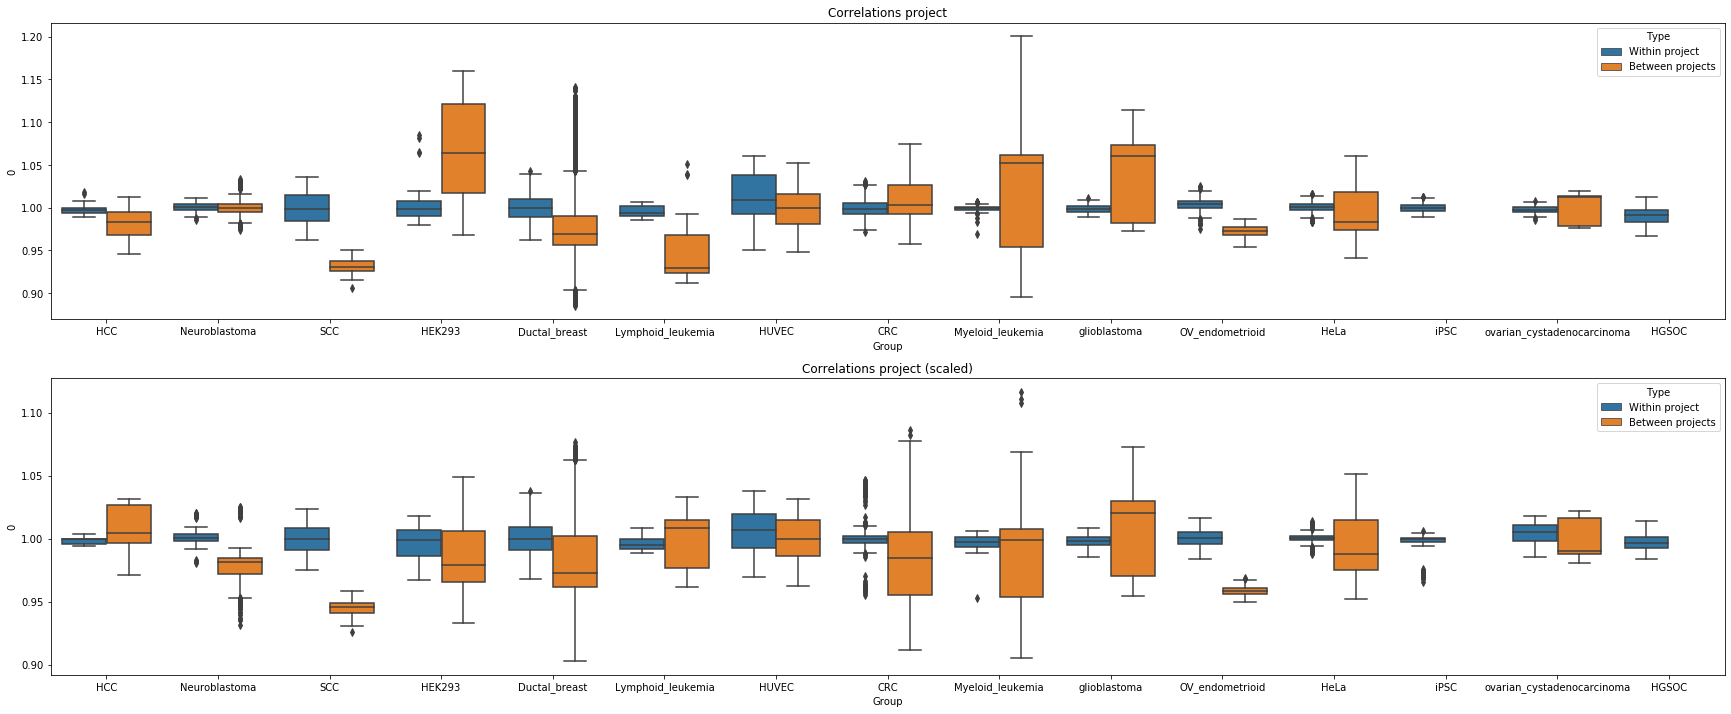

In [6]:
calculate_FC_bygroup(data_quantile)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    1.001015  Within project    HCC
 1    0.995164  Within project    HCC
 2    0.994882  Within project    HCC
 3    0.994934  Within project    HCC
 4    0.995128  Within project    HCC
 ..        ...             ...    ...
 856  1.003412  Within project  HGSOC
 857  1.003889  Within project  HGSOC
 858  1.003883  Within project  HGSOC
 859  1.004393  Within project  HGSOC
 860  1.000537  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    1.001134  Within project  HGSOC
 1    1.003406  Within project  HGSOC
 2    1.001435  Within project  HGSOC
 3    1.001252  Within project  HGSOC
 4    1.001438  Within project  HGSOC
 ..        ...             ...    ...
 856  1.003004  Within project  HGSOC
 857  1.003540  Within project  HGSOC
 858  1.002828  Within project  HGSOC
 859  1.003087  Within project  HGSOC
 860  1.000443  Within project  HGSOC
 
 [861 rows x 3 columns])

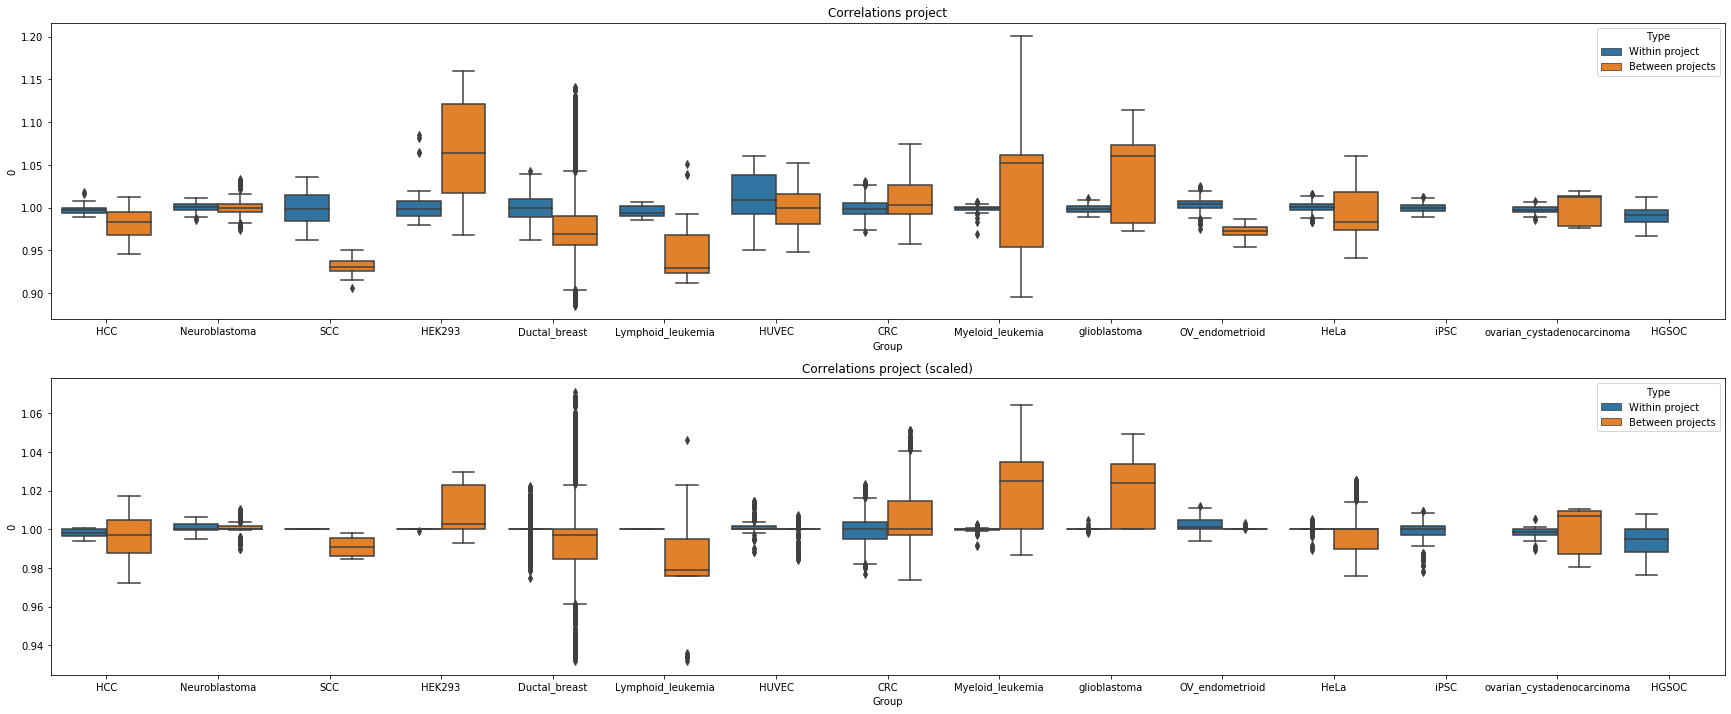

In [7]:
calculate_FC_bygroup(data_combat)

In [8]:
imputer_quant = LowestValueImputerGaussian()
imputer_nsaf = LowestValueImputerGaussian()
imputer_median_norm = LowestValueImputerGaussian()

In [9]:
imputer_quant_fitted = imputer_quant.fit(data_quantile)
imputer_nsaf_fitted = imputer_nsaf.fit(data_nsaf)
imputer_median_norm_fitted = imputer_median_norm.fit(data_median_norm)

In [7]:
print(data_quantile.isna().sum().sum()/(data_quantile.shape[0]*data_quantile.shape[1]), "missing value percentage")
print(data_quantile.isna().sum().sum(), "missing values")


0.24054054054054055 missing value percentage
325829 missing values


In [8]:
imputed_quantile = imputer_quant.transform(data_quantile)
imputed_nsaf = imputer_nsaf.transform(data_nsaf)
imputed_median_norm = imputer_median_norm.transform(data_median_norm)

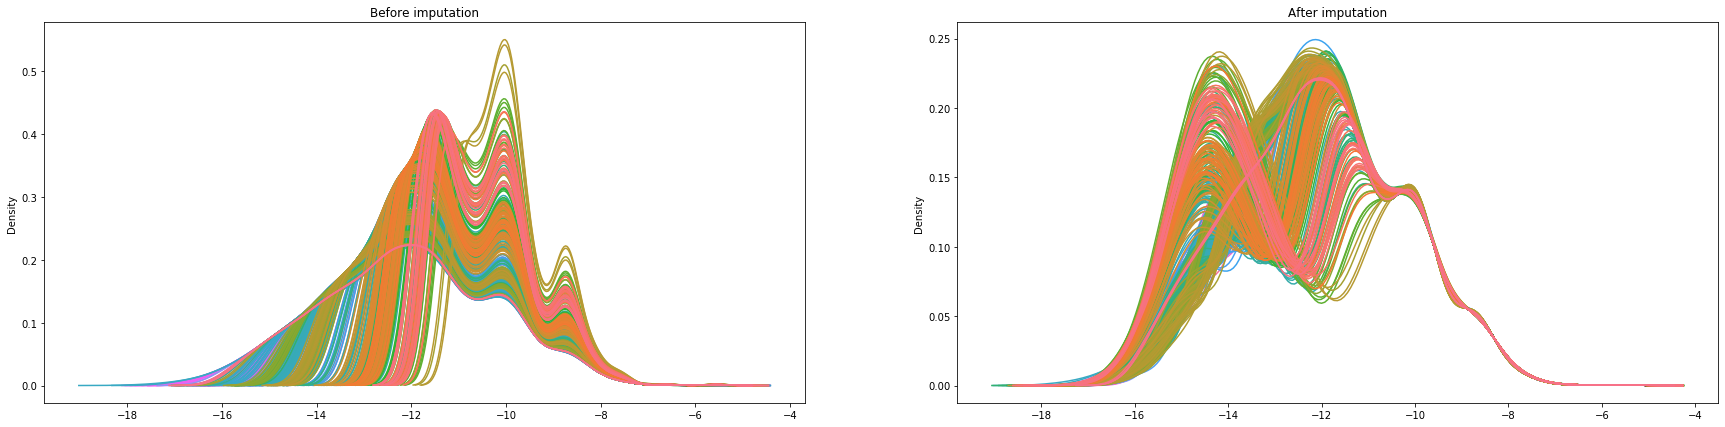

In [76]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('Before imputation')
sns.kdeplot(data=data_quantile.transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("After imputation")
sns.kdeplot(data=imputed_quantile.transpose(), legend = False, common_norm=False, ax =ax[1])

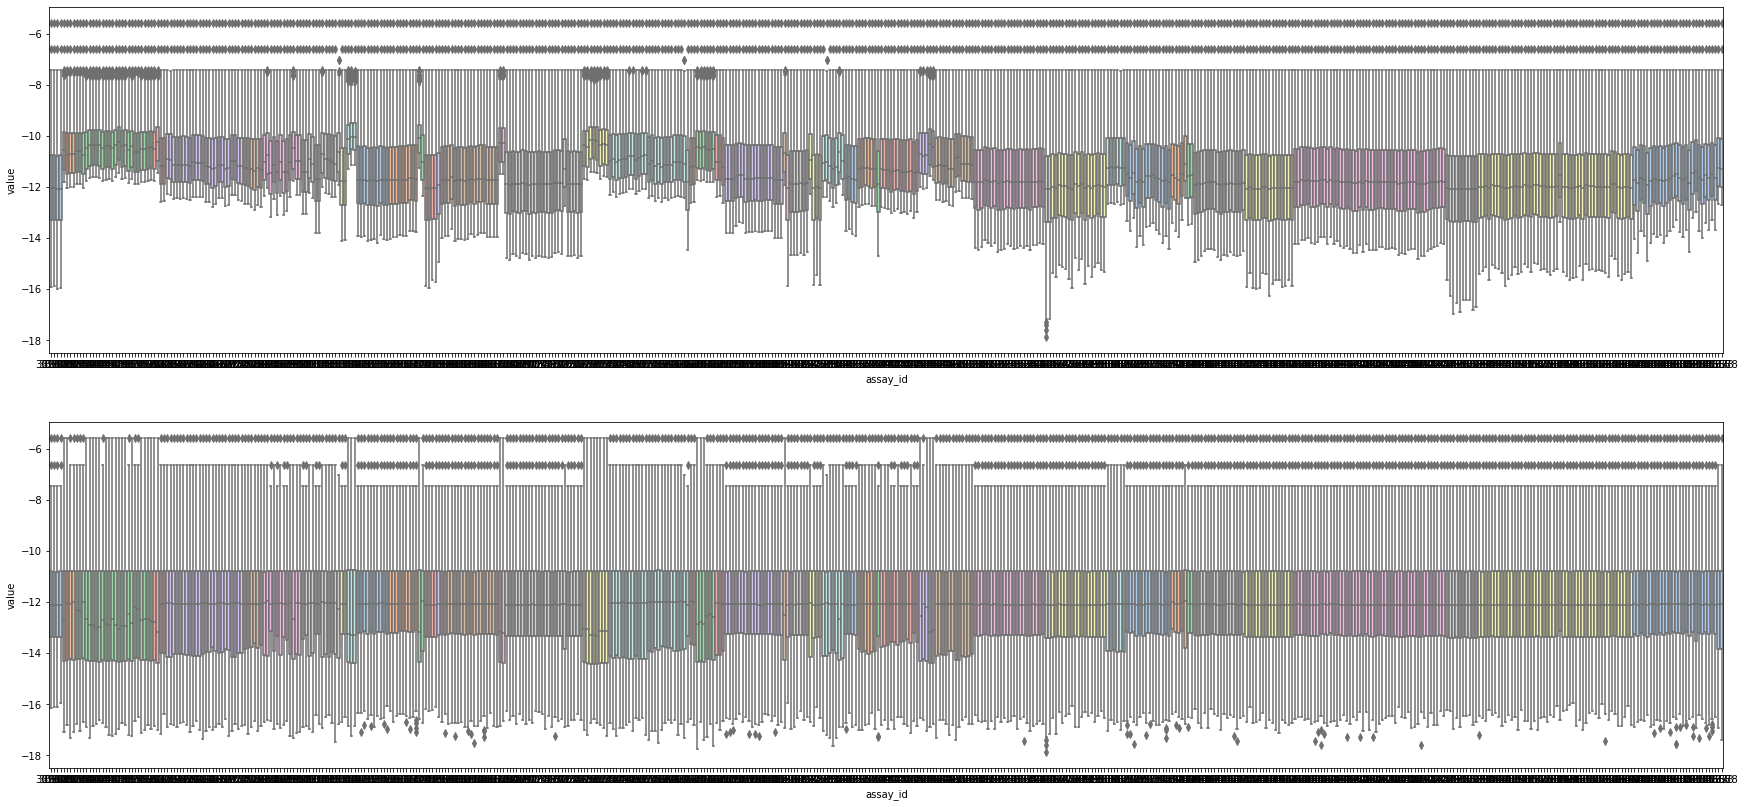

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_quantile.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_quantile.T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

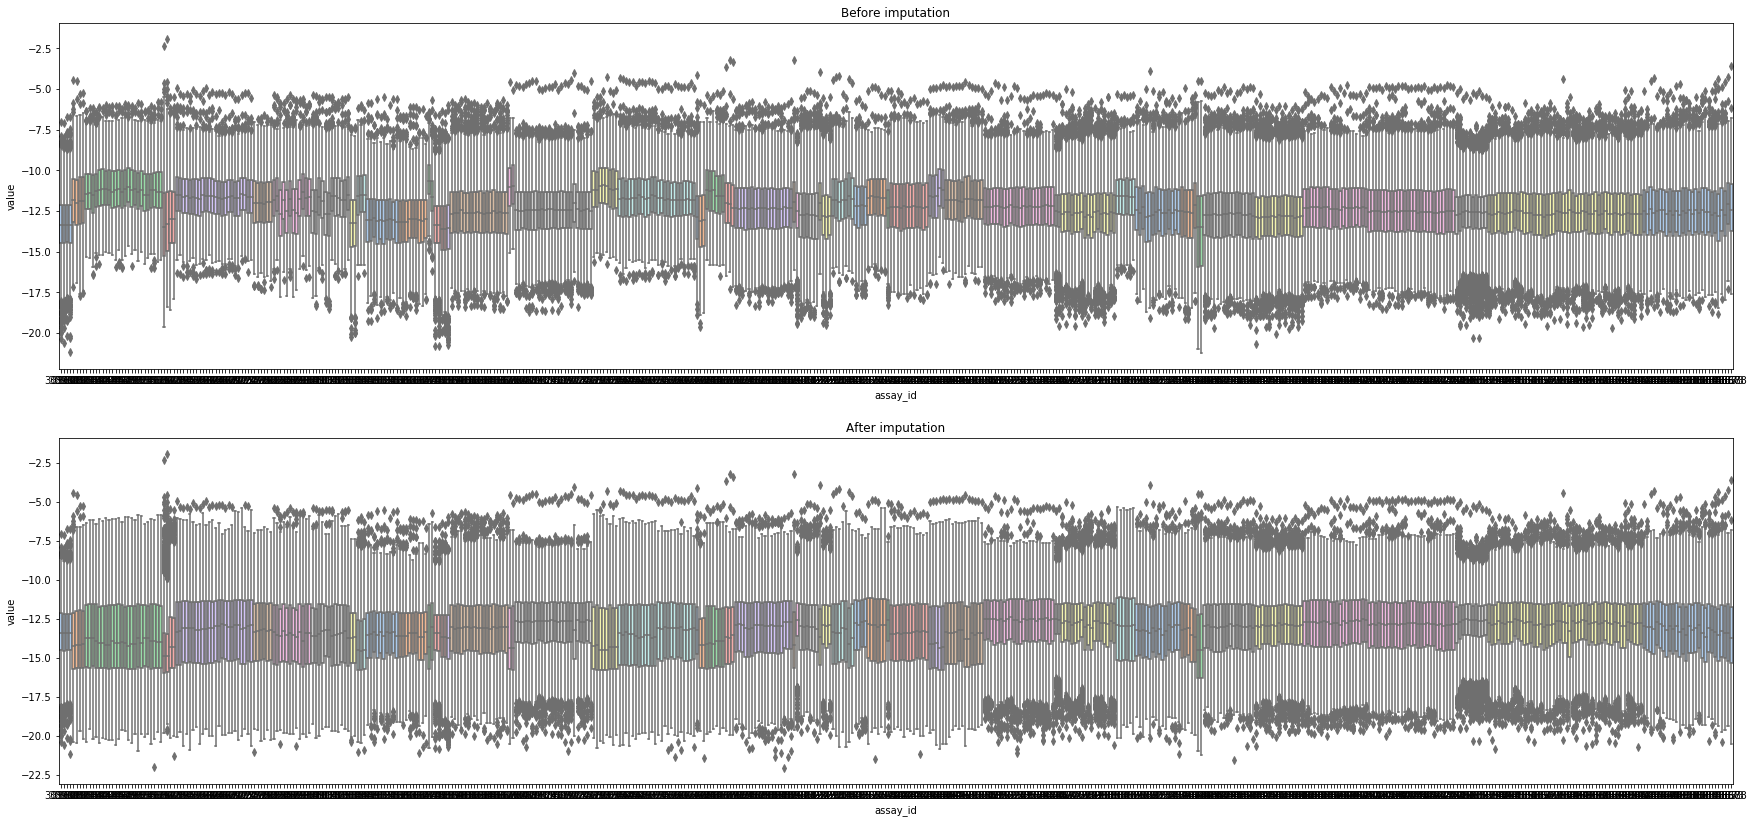

In [9]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_nsaf.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_nsaf.T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

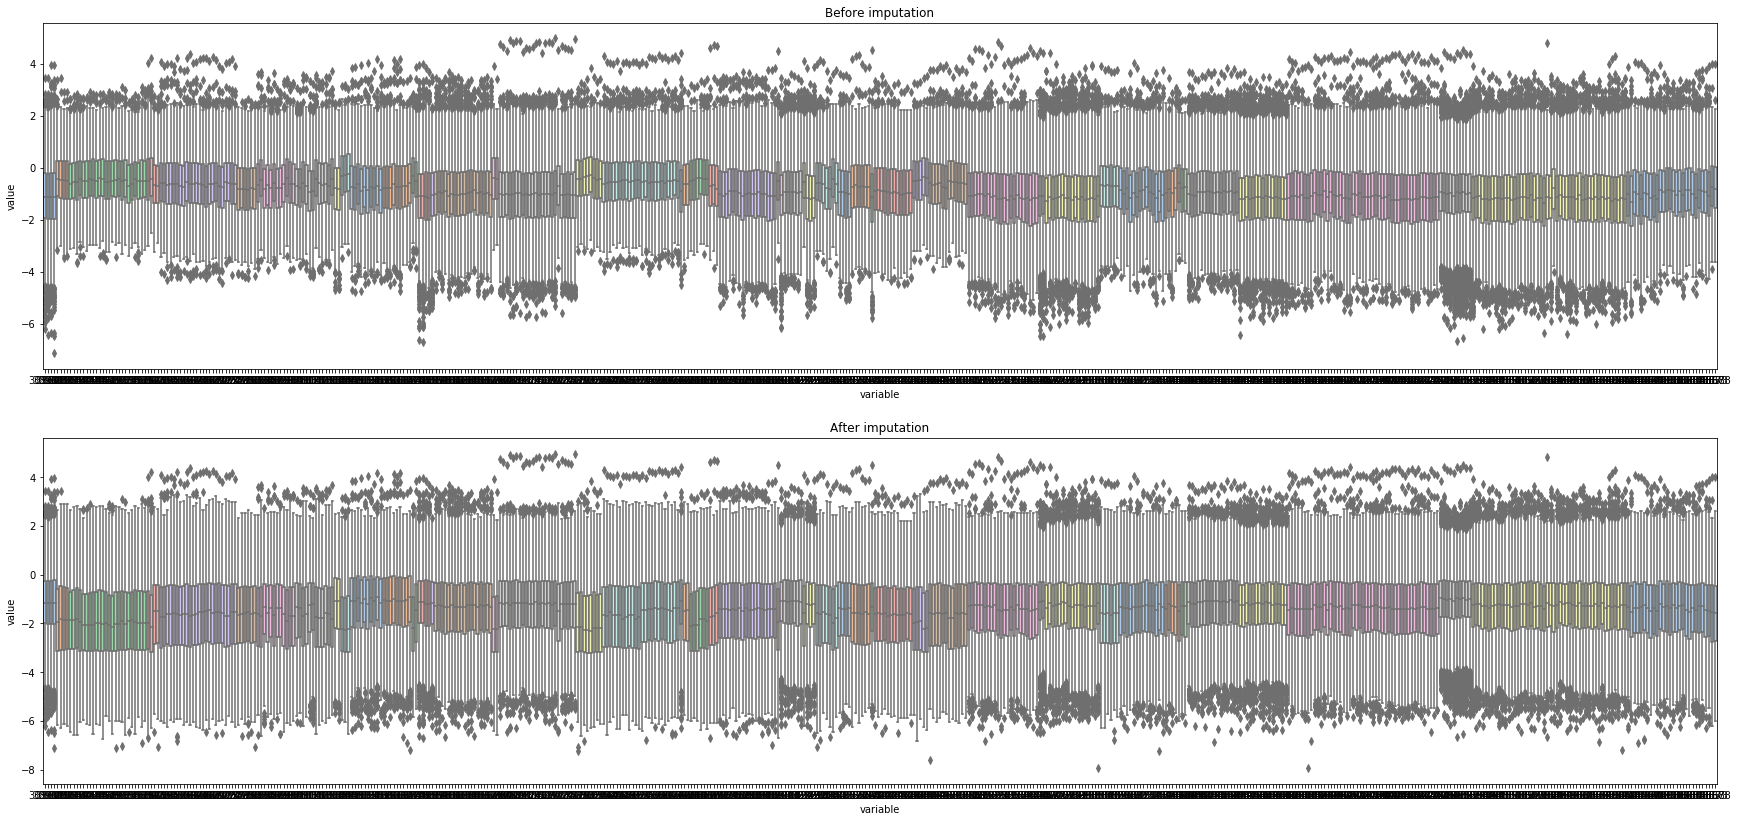

In [13]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_median_norm.T.melt().dropna(), y='value', x="variable", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_median_norm.T.melt().dropna(), y='value', x="variable", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)